In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
 
%config InlineBackend.figure_format = 'retina'
 
import matplotlib.font_manager as fm
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
plt.rc('font', family='NanumBarunGothic') 
mpl.font_manager._rebuild()

In [2]:
import tensorflow as tf
import numpy as np

from konlpy.tag import Mecab
from nltk.tokenize import word_tokenize

from sklearn.model_selection import train_test_split

import matplotlib.ticker as ticker
import matplotlib.pyplot as plt

import time
import re
import os
import io

print(tf.__version__)

2.2.0


# 1. 데이터 로드 및 확인

In [3]:
path_to_file_1 = os.getenv('HOME')+'/mini_projects/_G-04_seq2seq_NMT/korean-english-park.train.ko'
path_to_file_2 = os.getenv('HOME')+'/mini_projects/_G-04_seq2seq_NMT/korean-english-park.train.en'

In [4]:
with open(path_to_file_1, "r") as f:
    train_raw = f.read().splitlines()
    
print("Train Data Size:", len(train_raw))
print("Train_raw:", train_raw[0:3])

Train Data Size: 94123
Train_raw: ['개인용 컴퓨터 사용의 상당 부분은 "이것보다 뛰어날 수 있느냐?"', '모든 광마우스와 마찬가지 로 이 광마우스도 책상 위에 놓는 마우스 패드를 필요로 하지 않는다.', '그러나 이것은 또한 책상도 필요로 하지 않는다.']


In [5]:
with open(path_to_file_2, "r") as f:
    target_raw = f.read().splitlines()
    
print("Target Data Size:", len(target_raw))
print("Target_raw:", target_raw[0:3])

Target Data Size: 94123
Target_raw: ['Much of personal computing is about "can you top this?"', 'so a mention a few weeks ago about a rechargeable wireless optical mouse brought in another rechargeable, wireless mouse.', "Like all optical mice, But it also doesn't need a desk."]


# 2. 데이터 중복 확인 및 제거

In [6]:
cleaned_corpus = set(zip(train_raw,target_raw))

In [7]:
len(cleaned_corpus)

78968

In [8]:
q, r = len(set(train_raw)), len(set(target_raw))
print(q, r)

77591 75598


### 중복을 제거한 타겟셋 크기에 맞춰서 훈련셋 중복제거

In [9]:
train_dic = {}
for i, j in enumerate(train_raw):
    train_dic[i]=j
    
target_dic = {}
for i, j in enumerate(target_raw):
    target_dic[i]=j
    
target_unique_dic = {}
for i, j in target_dic.items():
    if j not in target_unique_dic.values():
        target_unique_dic[i] = j 
        
train_unique_dic = {}
for i, j in train_dic.items():
    if i in target_unique_dic.keys():
        train_unique_dic[i] = j 

print(len(train_unique_dic), len(target_unique_dic))

75598 75598


# 3. 데이터 전처리

In [10]:
cleaned_eng_corpus = {}
cleaned_kor_corpus = {}
mecab = Mecab()

def preprocess_sentence(train_unique_dic, target_unique_dic):
    
    for idx, sentence in target_unique_dic.items():
        sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
        sentence = re.sub(r'[" "]+', " ", sentence)
        sentence = re.sub(r"[^a-zA-Z0-9?.!,]+", " ", sentence)
        sentence = sentence.strip()
        sentence_list = sentence.split()
        if len(sentence_list) <= 38:
            sentence = '<start> ' + sentence
            sentence += ' <end>'
            sentence = sentence.split()
            cleaned_eng_corpus[idx] = sentence
    
    for idx, sentence in train_unique_dic.items():
        sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
        sentence = re.sub(r'[" "]+', " ", sentence)   
        sentence = re.sub(r"[^ㄱ-ㅎ가-힣0-9.,?!]+", " ", sentence)
        result = mecab.morphs(sentence)
        if len(result) <= 40:
            cleaned_kor_corpus[idx] = result
    
    return cleaned_eng_corpus, cleaned_kor_corpus

In [11]:
cleaned_eng_corpus, cleaned_kor_corpus = preprocess_sentence(train_unique_dic, target_unique_dic)

In [12]:
print(cleaned_eng_corpus[100], cleaned_kor_corpus[100])

['<start>', 'Gates', ',', 'who', 'opened', 'the', '23rd', 'annual', 'Comdex', 'trade', 'show', ',', 'said', 'there', 'was', 'a', 'negative', 'perception', 'of', 'high', 'tech', 'following', 'the', 'collapse', 'of', 'the', 'tech', 'bubble', 'about', 'two', 'years', 'ago', '.', '<end>'] ['제', '23', '차', '연례', '컴덱스', '박람회', '의', '개회사', '를', '한', '케이츠', '는', '2', '년', '여전', '기술', '산업', '의', '거품', '이', '붕괴', '된', '이후', '에', '첨단', '기술', '에', '대해', '부정', '적', '인', '인식', '이', '있', '다고', '말', '했', '다', '.']


In [13]:
print(len(cleaned_eng_corpus), len(cleaned_kor_corpus))

66290 62387


In [14]:
set_temp1 = set(cleaned_eng_corpus.keys())
set_temp2 = set(cleaned_kor_corpus.keys())
set_temp3 = set_temp2.intersection(set_temp1)
len(set_temp3)

58551

In [15]:
train_list = []
target_list = []

for i, j in cleaned_eng_corpus.items():
    if i in set_temp3:
        target_list.append(j)
        
for i, j in cleaned_kor_corpus.items():
    if i in set_temp3:
        train_list.append(j)
print(len(train_list), len(target_list))

58551 58551


In [16]:
del q
del r
del train_dic
del target_dic
del train_unique_dic
del target_unique_dic
del cleaned_eng_corpus
del cleaned_kor_corpus
del set_temp1
del set_temp2
del set_temp3

# 토크나이징

In [47]:
maxlen = 40
def tokenize(corpus):
    tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='', num_words=10000)
    tokenizer.fit_on_texts(corpus)

    tensor = tokenizer.texts_to_sequences(corpus)

    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post', maxlen = 40)

    return tensor, tokenizer

In [48]:
enc_tensor, enc_vocab = tokenize(train_list)
dec_tensor, dec_vocab = tokenize(target_list)

print("Korean Vocab Size:", len(enc_vocab.index_word))
print("English Vocab Size:", len(dec_vocab.index_word))

Korean Vocab Size: 37611
English Vocab Size: 39389


In [49]:
print(len(enc_tensor[12400]), len(dec_tensor[12400]))

40 40


# 모델 설계

In [50]:
class BahdanauAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.w_dec = tf.keras.layers.Dense(units)
        self.w_enc = tf.keras.layers.Dense(units)
        self.w_com = tf.keras.layers.Dense(1)
    
    def call(self, h_enc, h_dec):
        # h_enc shape: [batch x length x units]
        # h_dec shape: [batch x units]

        h_enc = self.w_enc(h_enc)
        h_dec = tf.expand_dims(h_dec, 1)
        h_dec = self.w_dec(h_dec)

        score = self.w_com(tf.nn.tanh(h_dec + h_enc))
        
        attn = tf.nn.softmax(score, axis=1)

        context_vec = attn * h_enc
        context_vec = tf.reduce_sum(context_vec, axis=1)

        return context_vec, attn

In [51]:
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, enc_units):
        super(Encoder, self).__init__()

        self.enc_units = enc_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(enc_units,
                                       return_sequences=True)

    def call(self, x):
        out = self.embedding(x)
        out = self.gru(out)

        return out


In [52]:
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, dec_units):
        super(Decoder, self).__init__()
        self.dec_units = dec_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(dec_units,
                                       return_sequences=True,
                                       return_state=True)
        self.fc = tf.keras.layers.Dense(vocab_size)

        self.attention = BahdanauAttention(self.dec_units)

    def call(self, x, h_dec, enc_out):
        context_vec, attn = self.attention(enc_out, h_dec)

        out = self.embedding(x)
        out = tf.concat([tf.expand_dims(context_vec, 1), out], axis=-1)

        out, h_dec = self.gru(out)
        out = tf.reshape(out, (-1, out.shape[2]))
        out = self.fc(out)

        return out, h_dec, attn

In [53]:
# 코드를 실행하세요.

BATCH_SIZE     = 64
SRC_VOCAB_SIZE = len(enc_vocab.index_word) + 1 
TGT_VOCAB_SIZE = len(dec_vocab.index_word) + 1 

units         = 128
embedding_dim = 128

encoder = Encoder(SRC_VOCAB_SIZE, embedding_dim, units)
decoder = Decoder(TGT_VOCAB_SIZE, embedding_dim, units)

# sample input
sequence_len = 40

sample_enc = tf.random.uniform((BATCH_SIZE, sequence_len))
sample_output = encoder(sample_enc)

print ('Encoder Output:', sample_output.shape)

sample_state = tf.random.uniform((BATCH_SIZE, units))

sample_logits, h_dec, attn = decoder(tf.random.uniform((BATCH_SIZE, 1)),
                                     sample_state, sample_output)

print ('Decoder Output:', sample_logits.shape)
print ('Decoder Hidden State:', h_dec.shape)
print ('Attention:', attn.shape)

Encoder Output: (64, 40, 128)
Decoder Output: (64, 39390)
Decoder Hidden State: (64, 128)
Attention: (64, 40, 1)


In [54]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss = loss_object(real, pred)
    
    mask = tf.cast(mask, dtype=loss.dtype)
    loss *= mask
    
    return tf.reduce_mean(loss)

In [55]:
@tf.function
def train_step(src, tgt, encoder, decoder, optimizer, dec_tok):
    bsz = src.shape[0]
    loss = 0

    with tf.GradientTape() as tape:
        enc_out = encoder(src)
        h_dec = enc_out[:, -1]
        
        dec_src = tf.expand_dims([dec_tok.word_index['<start>']] * bsz, 1)

        for t in range(1, tgt.shape[1]):
            pred, h_dec, _ = decoder(dec_src, h_dec, enc_out)

            loss += loss_function(tgt[:, t], pred)
            dec_src = tf.expand_dims(tgt[:, t], 1)
        
    batch_loss = (loss / int(tgt.shape[1]))

    variables = encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(loss, variables)
    optimizer.apply_gradients(zip(gradients, variables))
    
    return batch_loss

# 모델 훈련

In [56]:
from tqdm import tqdm    # tqdm
import random

EPOCHS = 15

for epoch in range(EPOCHS):
    total_loss = 0
    
    idx_list = list(range(0, enc_tensor.shape[0], BATCH_SIZE))
    random.shuffle(idx_list)
    t = tqdm(idx_list)    # tqdm

    for (batch, idx) in enumerate(t):
        batch_loss = train_step(enc_tensor[idx:idx+BATCH_SIZE],
                                dec_tensor[idx:idx+BATCH_SIZE],
                                encoder,
                                decoder,
                                optimizer,
                                dec_vocab)
    
        total_loss += batch_loss
        
        t.set_description_str('Epoch %2d' % (epoch + 1))    # tqdm
        t.set_postfix_str('Loss %.4f' % (total_loss.numpy() / (batch + 1)))    # tqdm

Epoch 15: 100%|██████████| 915/915 [02:08<00:00,  7.10it/s, Loss 2.2581]


In [85]:
def preprocess_sentence(sentence):

    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)   
    sentence = re.sub(r"[^ㄱ-ㅎ가-힣0-9.,?!]+", " ", sentence)
    result = mecab.morphs(sentence)

    return result

In [94]:
def evaluate(sentence, encoder, decoder):
    attention = np.zeros((dec_tensor.shape[-1], enc_tensor.shape[-1]))
    
    sentence = preprocess_sentence(sentence)
    inputs = enc_vocab.texts_to_sequences([sentence])
    inputs = tf.keras.preprocessing.sequence.pad_sequences(inputs,
                                                           maxlen=enc_tensor.shape[-1],
                                                           padding='post')

    result = ''

    enc_out = encoder(inputs)

    dec_hidden = enc_out[:, -1]
    dec_input = tf.expand_dims([dec_vocab.word_index['<start>']], 0)

    for t in range(dec_tensor.shape[-1]):
        predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                             dec_hidden,
                                                             enc_out)

        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention[t] = attention_weights.numpy()

        predicted_id = \
        tf.argmax(tf.math.softmax(predictions, axis=-1)[0]).numpy()

        result += dec_vocab.index_word[predicted_id] + ' '

        if dec_vocab.index_word[predicted_id] == '<end>':
            return result, sentence, attention

        dec_input = tf.expand_dims([predicted_id], 0)

    return result, sentence, attention


def plot_attention(attention, sentence, predicted_sentence):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')

    fontdict = {'fontsize': 14}

    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()


def translate(sentence, encoder, decoder):
    result, sentence, attention = evaluate(sentence, encoder, decoder)

    print('Input: %s' % (sentence))
    print('Predicted translation: {}'.format(result))
    
    attention = attention[:len(result), :len(sentence)]
    plot_attention(attention, sentence, result.split(' '))



Input: ['일곱', '명', '의', '사망자', '가', '발생', '했', '다', '.']
Predicted translation: the two people were killed . <end> 


/home/aiffel/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:45: UserWarning: FixedFormatter should only be used together with FixedLocator
/home/aiffel/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:46: UserWarning: FixedFormatter should only be used together with FixedLocator


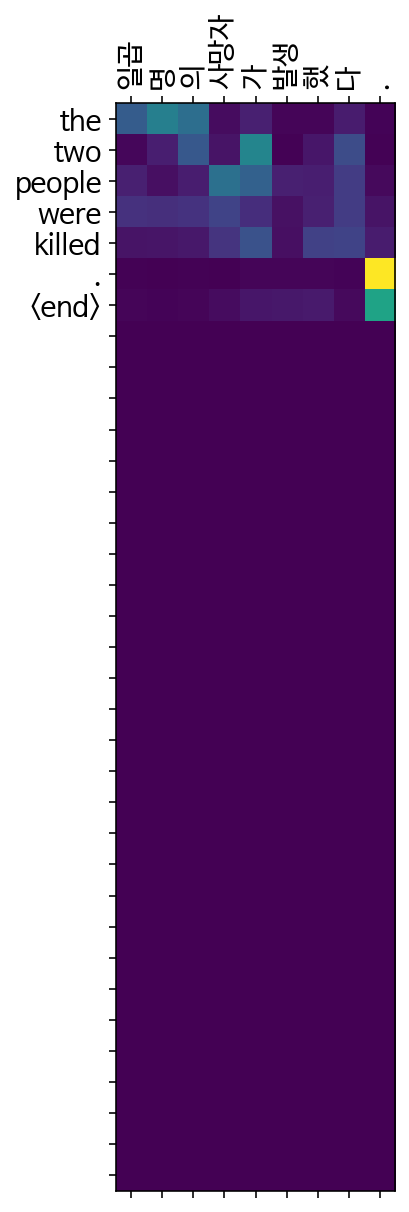

In [95]:
translate("일곱 명의 사망자가 발생했다.", encoder, decoder)

Input: ['커피', '는', '필요', '없', '다', '.']
Predicted translation: you don t think that you can t be a lot of the . <end> 


/home/aiffel/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:45: UserWarning: FixedFormatter should only be used together with FixedLocator
/home/aiffel/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:46: UserWarning: FixedFormatter should only be used together with FixedLocator


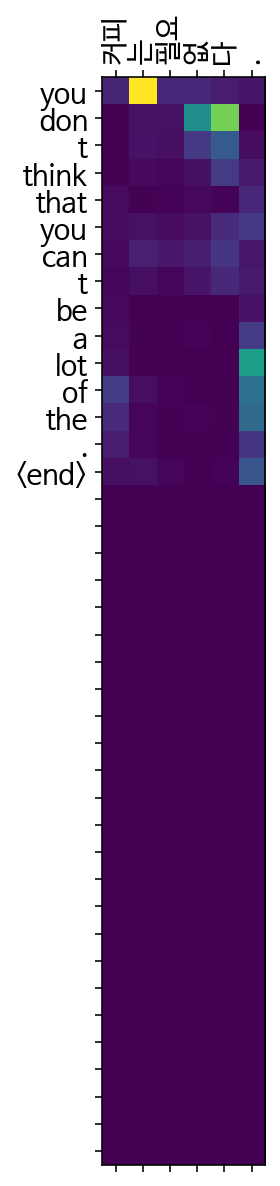

In [96]:
translate("커피는 필요 없다.", encoder, decoder)

Input: ['시민', '들', '은', '도시', '속', '에', '산다', '.']
Predicted translation: the woman who are in the world . <end> 


/home/aiffel/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:45: UserWarning: FixedFormatter should only be used together with FixedLocator
/home/aiffel/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:46: UserWarning: FixedFormatter should only be used together with FixedLocator


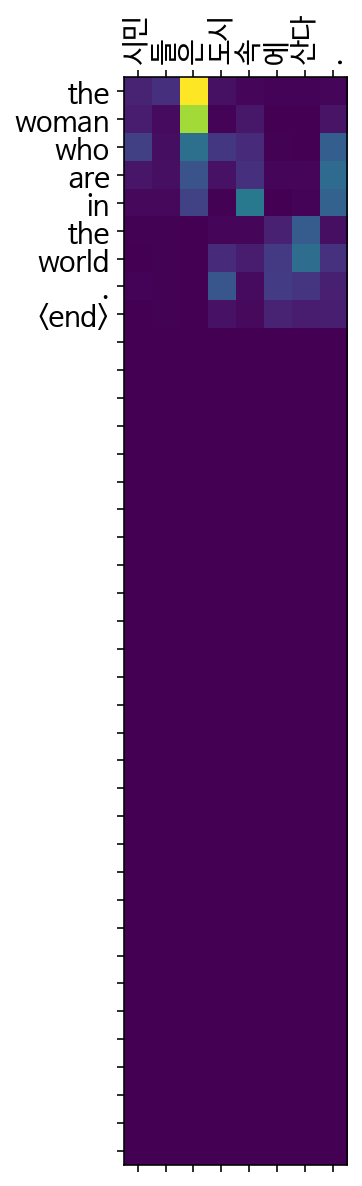

In [97]:
translate("시민들은 도시 속에 산다.", encoder, decoder)

Input: ['오바마', '는', '대통령', '이', '다', '.']
Predicted translation: obama is a bill . <end> 


/home/aiffel/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:45: UserWarning: FixedFormatter should only be used together with FixedLocator
/home/aiffel/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:46: UserWarning: FixedFormatter should only be used together with FixedLocator


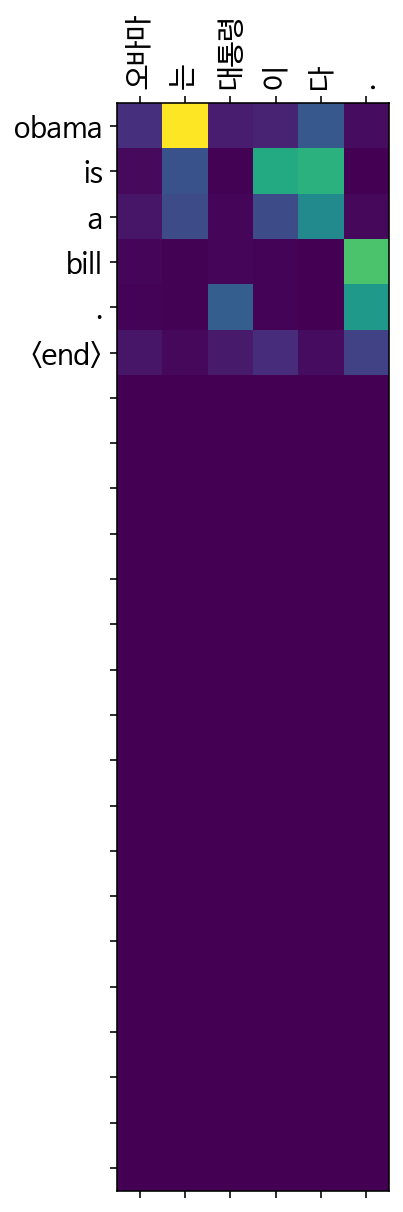

In [98]:
translate("오바마는 대통령이다.", encoder, decoder)